In [32]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [33]:
# Load dataset
data = pd.read_csv(r'processed_data\preprocessed_training.csv')
X = data.drop(columns=["Churn"])
y = data["Churn"]

In [34]:

# Holdout validation set (10%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

X_train["Contract_Ratio"] = X_train["Contract Length_Annual"] / (X_train["Contract Length_Quarterly"] + 1)

# K-Fold Cross Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Model selection toggles
enable_logistic = False
enable_random_forest = False
enable_xgboost = True
enable_lightgbm = False

models = {
    "Logistic Regression": LogisticRegression(max_iter=500) if enable_logistic else None,
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42) if enable_random_forest else None,
    "XGBoost": XGBClassifier(n_estimators=500, learning_rate=0.01, max_depth=4, eval_metric='aucpr',scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1])) if enable_xgboost else None,
    "LightGBM": LGBMClassifier(n_estimators=100, learning_rate=0.05, max_depth=4) if enable_lightgbm else None
}

In [35]:

# Train and evaluate models
best_model = None
best_accuracy = 0

for name, model in models.items():
    if model is None:
        continue
    
    fold_accuracies = []
    for train_idx, val_idx in kf.split(X_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_val)
        val_accuracy = accuracy_score(y_fold_val, y_pred)
        fold_accuracies.append(val_accuracy)
    
    avg_accuracy = np.mean(fold_accuracies)
    print(f"{name} - Average CV Accuracy: {avg_accuracy:.4f}")
    
    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_model = (name, model)

XGBoost - Average CV Accuracy: 0.9845


In [36]:
# Load test dataset
test_data = pd.read_csv(r"processed_data\preprocessed_testing.csv")
X_test = test_data.drop(columns=["Churn"])
y_test = test_data["Churn"]

X_test["Contract_Ratio"] = X_test["Contract Length_Annual"] / (X_test["Contract Length_Quarterly"] + 1)

# Evaluate best model
model_name, model = best_model
print(f"\nBest Model: {model_name}")
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]

# optimal_threshold = 0.85  # Try different values
# y_pred = (y_probs > optimal_threshold).astype("int32")

from sklearn.metrics import precision_recall_curve
prec, rec, thresholds = precision_recall_curve(y_test, y_probs)

# Choose a threshold where precision and recall are balanced
optimal_threshold = thresholds[np.argmax(prec * rec)]
y_pred = (y_probs > optimal_threshold).astype("int32")

# Classification Report
print(classification_report(y_test, y_pred))


Best Model: XGBoost
              precision    recall  f1-score   support

           0       0.84      0.36      0.51     33881
           1       0.57      0.92      0.70     30493

    accuracy                           0.63     64374
   macro avg       0.70      0.64      0.61     64374
weighted avg       0.71      0.63      0.60     64374



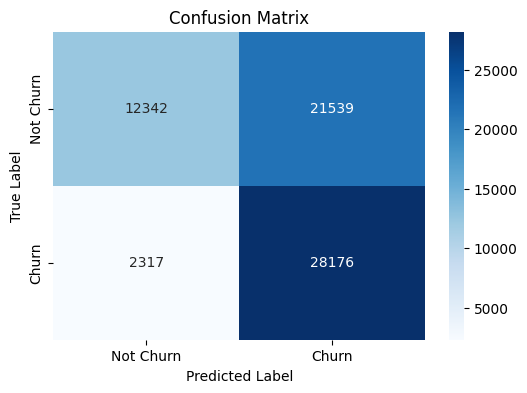

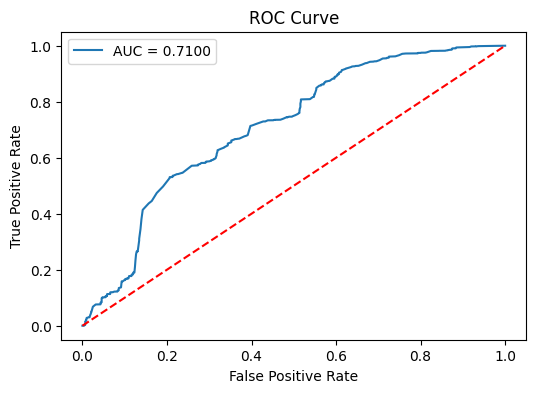

In [37]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Churn", "Churn"], yticklabels=["Not Churn", "Churn"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
auc_score = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [38]:
# Save best model
joblib.dump(model, "best_model.joblib")
print(f"Best model saved as best_model.joblib")


Best model saved as best_model.joblib


In [41]:
import pandas as pd

# Get feature importance
feature_importance = pd.DataFrame(
    {"Feature": X_train.columns, "Importance": model.feature_importances_}
)

# Sort by absolute importance
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Display the top 10 most important features
print(feature_importance)


                       Feature  Importance
3                  Total Spend    0.217216
1                Support Calls    0.206543
11     Contract Length_Monthly    0.132247
21           Age_group_54 - 65    0.121818
2                Payment Delay    0.104534
5                Gender_Female    0.102547
18           Age_group_18 - 29    0.046380
4             Last Interaction    0.037987
20           Age_group_42 - 53    0.026302
19           Age_group_30 - 41    0.004134
14        tenure_group_13 - 24    0.000113
0              Usage Frequency    0.000087
9   Subscription Type_Standard    0.000087
10      Contract Length_Annual    0.000006
6                  Gender_Male    0.000000
13         tenure_group_1 - 12    0.000000
12   Contract Length_Quarterly    0.000000
8    Subscription Type_Premium    0.000000
7      Subscription Type_Basic    0.000000
17        tenure_group_49 - 60    0.000000
16        tenure_group_37 - 48    0.000000
15        tenure_group_25 - 36    0.000000
22         

<Figure size 800x600 with 0 Axes>

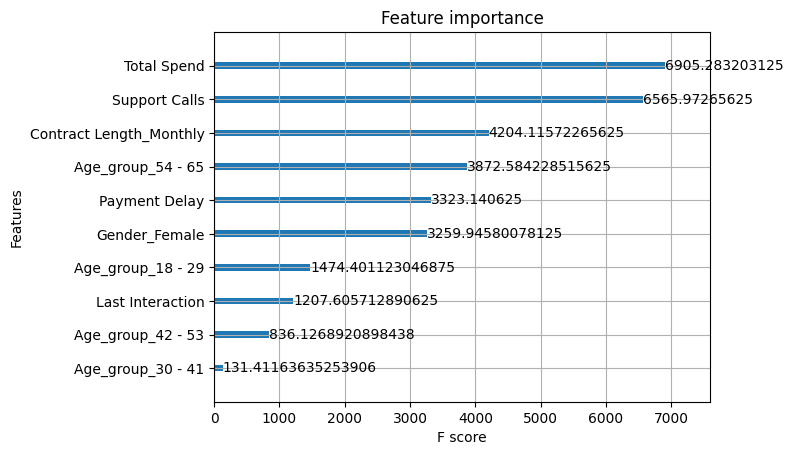

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plot_importance(model, importance_type="gain", max_num_features=10)  # You can change to "weight" or "cover"
plt.show()